In [2]:
# Import packages
import os as os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Initialize parameters
def initialize_parameters(layers_dims):
    """
    Initialize parameters dictionary.
    
    Weight matrices will be initialized to random values from uniform normal
    distribution.
    bias vectors will be initialized to zeros.

    Arguments
    ---------
    layers_dims : list or array-like
        dimensions of each layer in the network.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)

    return parameters

In [0]:
# Define activation functions that will be used in forward propagation
def sigmoid(Z):
    """
    Computes the sigmoid of Z element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = 1 / (1 + np.exp(-Z))

    return A, Z


def tanh(Z):
    """
    Computes the Hyperbolic Tagent of Z elemnet-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.tanh(Z)

    return A, Z


def relu(Z):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0, Z)

    return A, Z


def leaky_relu(Z):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0.1 * Z, Z)

    return A, Z

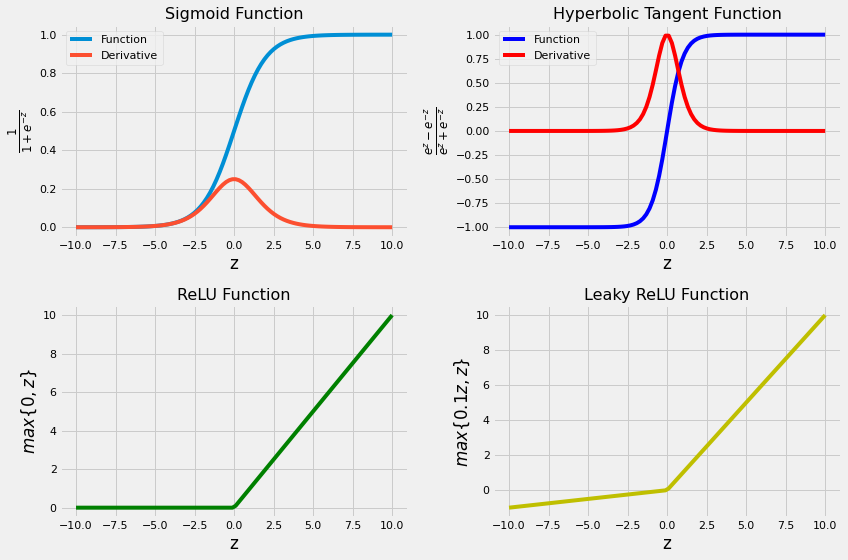

In [5]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label = "Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize = 16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize = 16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize = 16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize = 16)
plt.tight_layout();

In [0]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    """
    Computes affine transformation of the input.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.

    Returns
    -------
    Z : 2d-array
        affine transformation output.
    cache : tuple
        stores A_prev, W, b to be used in backpropagation.
    """
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    """
    Computes post-activation output using non-linear activation function.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.
    activation_fn : str
        non-linear activation function to be used: "sigmoid", "tanh", "relu".

    Returns
    -------
    A : 2d-array
        output of the activation function.
    cache : tuple
        stores linear_cache and activation_cache. ((A_prev, W, b), Z) to be used in backpropagation.
    """
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu"):
    """
    Computes the output layer through looping over all units in topological
    order.

    Arguments
    ---------
    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
    """
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])

    return AL, caches

In [0]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    """
    Computes the binary Cross-Entropy cost.

    Arguments
    ---------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    y : 2d-array
        true "label" vector.

    Returns
    -------
    cost : float
        binary cross-entropy cost.
    """
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))

    return cost

In [0]:
# Define derivative of activation functions w.r.t z that will be used in back-propagation
def sigmoid_gradient(dA, Z):
    """
    Computes the gradient of sigmoid output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    """
    Computes the gradient of hyperbolic tangent output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    """
    Computes the gradient of ReLU output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.

    Arguments
    ---------
    dZ : 2d-array
        gradient of the cost w.r.t. the linear output (of current layer l).
    cache : tuple
        values of (A_prev, W, b) coming from the forward propagation in the current layer.

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1).
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l).
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l).
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    """
    Arguments
    ---------
    dA : 2d-array
        post-activation gradient for current layer l.
    cache : tuple
        values of (linear_cache, activation_cache).
    activation : str
        activation used in this layer: "sigmoid", "tanh", or "relu".

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1), same shape as A_prev.
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l), same shape as W.
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l), same shape as b.
    """
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu"):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "tanh", "relu".

    Returns
    -------
    grads : dict
        with the gradients.
    """
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], "sigmoid")

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)

    return grads


# define the function to update both weight matrices and bias vectors
def update_parameters(parameters, grads, learning_rate):
    """
    Update the parameters' values using gradient descent rule.

    Arguments
    ---------
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    grads : dict
        stores all gradients (output of L_model_backward).

    Returns
    -------
    parameters : dict
        updated parameters.
    """
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

Original dimensions:
--------------------
Training: (209, 64, 64, 3), (209,)
Test: (50, 64, 64, 3), (50,)

New dimensions:
---------------
Training: (12288, 209), (1, 209)
Test: (12288, 50), (1, 50)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """


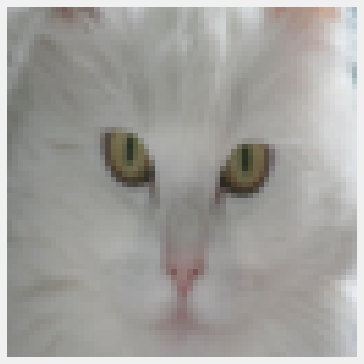

In [9]:
# Import training dataset
train_dataset = h5py.File("train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])
y_train = np.array(train_dataset["train_set_y"])

test_dataset = h5py.File("test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
y_test = np.array(test_dataset["test_set_y"])

# print the shape of input data and label vector
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

# plot cat image
plt.figure(figsize=(6, 6))
plt.imshow(X_train[50])
plt.axis("off");

# Transform input data and label vector
X_train = X_train.reshape(209, -1).T
y_train = y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
y_test = y_test.reshape(-1, 50)

# standarize the data
X_train = X_train / 255
X_test = X_test / 255

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

In [0]:
# Define the multi-layer model using all the helper functions we wrote before

def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=True, hidden_layers_activation_fn="relu"):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test examples.
    """
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y, activation_fn="relu"):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100

    return f"The accuracy rate is: {accuracy:.2f}%."

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6439
The cost after 900 iterations is: 0.6439
The cost after 1000 iterations is: 0.6439
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6438
The cost after 1400 iterations is: 0.6438
The cost after 1500 iterations is: 0.6437
The cost after 1600 iterations is: 0.6434
The cost after 1700 iterations is: 0.6429
The cost after 1800 iterations is: 0.6413
The cost after 1900 iterations is: 0.6361
The cost after 2000 iterations is: 0.6124
The cost after 2100 iterations is: 0.5112
The cost after 2200 iterations is: 0.4608
The cost after 2300 iterations is: 0.5472
The cost after 2400 iterations is: 0.3600
T

'The accuracy rate is: 32.00%.'

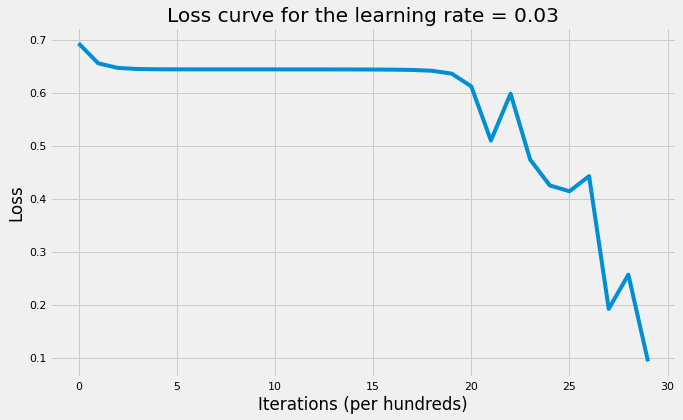

In [22]:
# Setting layers dims
layers_dims = [X_train.shape[0], 5, 5, 1]

# NN with tanh activation fn
parameters_tanh = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000,
    hidden_layers_activation_fn="tanh")

# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="tanh")

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6440
The cost after 900 iterations is: 0.6440
The cost after 1000 iterations is: 0.6440
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6439
The cost after 1400 iterations is: 0.6439
The cost after 1500 iterations is: 0.6439
The cost after 1600 iterations is: 0.6439
The cost after 1700 iterations is: 0.6438
The cost after 1800 iterations is: 0.6437
The cost after 1900 iterations is: 0.6435
The cost after 2000 iterations is: 0.6432
The cost after 2100 iterations is: 0.6423
The cost after 2200 iterations is: 0.6395
The cost after 2300 iterations is: 0.6259
The cost after 2400 iterations is: 0.5408
T

'The accuracy rate is: 42.00%.'

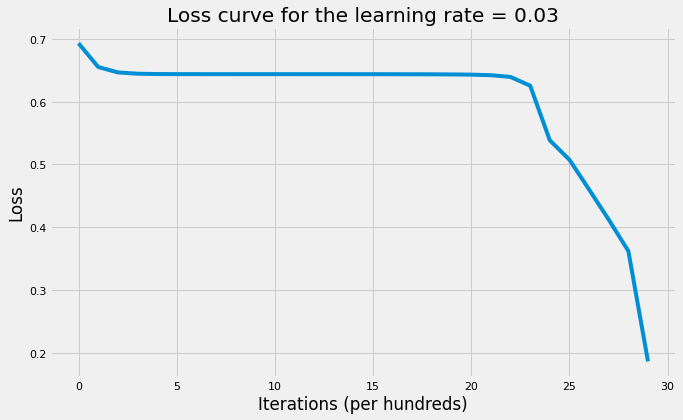

In [23]:
layers_dims = [X_train.shape[0], 5, 5, 1]
# NN with relu activation fn
parameters_relu = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000,
    hidden_layers_activation_fn="relu")

# Print the accuracy
accuracy(X_test, parameters_relu, y_test, activation_fn="relu")

In [25]:
# Trying to make a flatten structure, and increase performance
from time import time
def train(model, X, y, learning_rate, epochs):
  np.random.seed(1)
  cost_list = []
  start = time()
  for epoch in range(epochs):
    for i, layer in enumerate(model['layers']):
      # Initialize weights and biases for the layer if have not been already initialized
      if layer['W'] is None:
        layer['W'], = np.random.randn(layer['units'], model['layers'][i-1]['units'] if i > 0 else X.shape[0]) * 0.01,
        layer['b'] = np.zeros((layer['units'], 1))
      # Forward
      layer['Z'] = np.dot(layer['W'], model['layers'][i-1]['A'] if i > 0 else X) + layer['b']
      layer['A'] = layer['activation'](layer['Z'])[0]

    # Backward - Backpropagation and Gradient Decent
    model['layers'][-1]['dA'] = np.divide(model['layers'][-1]['A'] - y,
      np.multiply(model['layers'][-1]['A'], 1 - model['layers'][-1]['A']))
    for i, layer in reversed(list(enumerate(model['layers']))):
      if layer['activation'].__name__ == 'relu':
        layer['dZ'] = np.multiply(layer['dA'], np.int64(layer['A'] > 0))
      else:
        layer['dZ'] = layer['dA']*layer['A']*(1-layer['A'])
      m = model['layers'][i-1]['A'].shape[1] if i > 0 else X.shape[1]
      layer['dW'] = (1 / m) * np.dot(layer['dZ'], model['layers'][i-1]['A'].T if i > 0 else X.T)
      layer['db'] = (1 / m) * np.sum(layer['dZ'], axis=1, keepdims=True)
      model['layers'][i-1]['dA'] = np.dot(layer['W'].T, layer['dZ'])

      # Update params - Gradient Decent
      layer['W'] -= learning_rate * layer['dW']
      layer['b'] -= learning_rate * layer['db']

    # Save/print cost
    if (epoch + 1) % 100 == 0:
      cost = - (1 / y.shape[1]) * np.sum(
        np.multiply(y, np.log(model['layers'][-1]['A'])) + 
        np.multiply(1 - y, np.log(1 - model['layers'][-1]['A']))
      )
      cost_list.append(cost)
      print(f"The cost after {epoch + 1} iterations is: {cost:.4f} - Duration : {time() - start}")
      start = time()

defauls = {'A_prev': None, 'W': None, 'b': None, 'Z': None, 'A': None, 'dZ': None, 'dA': None, 'dW': None, 'db': None}
model1 = {
  'input_shape': X_train.shape[0],
  'layers': [
             {'units': 5, 'activation': relu, **defauls},
             {'units': 5, 'activation': relu, **defauls},
             {'units': 1, 'activation': sigmoid, **defauls},
             ],
}
train(model1, X_train, y_train, learning_rate=0.03, epochs=3000)


The cost after 100 iterations is: 0.6556 - Duration : 1.9344031810760498
The cost after 200 iterations is: 0.6468 - Duration : 1.8901078701019287
The cost after 300 iterations is: 0.6447 - Duration : 1.8961031436920166
The cost after 400 iterations is: 0.6441 - Duration : 1.9147748947143555
The cost after 500 iterations is: 0.6440 - Duration : 1.9801361560821533
The cost after 600 iterations is: 0.6440 - Duration : 1.95448637008667
The cost after 700 iterations is: 0.6440 - Duration : 1.9113562107086182
The cost after 800 iterations is: 0.6440 - Duration : 1.9343359470367432
The cost after 900 iterations is: 0.6440 - Duration : 1.9215822219848633
The cost after 1000 iterations is: 0.6440 - Duration : 1.9050688743591309
The cost after 1100 iterations is: 0.6439 - Duration : 1.9411537647247314
The cost after 1200 iterations is: 0.6439 - Duration : 1.9098539352416992
The cost after 1300 iterations is: 0.6439 - Duration : 1.8969449996948242
The cost after 1400 iterations is: 0.6439 - Durat

In [28]:
# Even a better approach
from time import time
def train2(model, X, y, learning_rate, epochs):
  np.random.seed(1)
  cost_list = []
  start = time()
  for epoch in range(epochs):
    # Forward
    for i, layer in enumerate(model['layers']):
      layer.forward()

    # Backward - Backpropagation and Gradient Decent
    for i, layer in reversed(list(enumerate(model['layers']))):
      layer.update(learning_rate)

    # Save/print cost
    if (epoch + 1) % 100 == 0:
      cost = - (1 / y.shape[1]) * np.sum(
        np.multiply(y, np.log(model['layers'][-1].a)) + 
        np.multiply(1 - y, np.log(1 - model['layers'][-1].a))
      )
      cost_list.append(cost)
      print(f"The cost after {epoch + 1} iterations is: {cost:.4f} - Duration : {time() - start}")
      start = time()

class Layer:
  w = None
  b = None
  dw = None
  db = None
  y = None

  def __init__(self, name='', units=None, activation=None):
    self.name = name
    self.units = units
    self.activation = activation

  def __call__(self, prev):
    self.prev = prev
    if isinstance(self.prev, Layer):
      self.input_dim = self.prev.units
    self.init()
    return self

  def get_index(self):
    return {
        'first': None,
        'second': 2,
        'third': 1,
        'last': 0,
    }[self.name]

  def init(self):
    if self.w is None:
      self.w = np.random.randn(self.units, self.input_dim) * 0.01
      self.b = np.zeros((self.units, 1))

  def forward(self):
    pass

  def backward(self):
    pass

  # Update params - Gradient Decent
  def update(self, learning_rate):
    self.backward()
    if self.dw is not None:
      self.w -= learning_rate * self.dw
    if self.db is not None:
      self.b -= learning_rate * self.db
  
class Input(Layer):
  def init(self):
    self.input_dim = self.prev.shape[0]
    self.units = self.input_dim
    self.a = self.prev
    self.w = 0
    super().init()

class Dense(Layer):
  def set_y(self, y):
    self.y = y
    return self

  def forward(self):
    self.z = np.dot(self.w, self.prev.a) + self.b
    self.a = self.activation(self.z)[0]

  # Backward - Backpropagation and Gradient Decent
  def backward(self):
    if self.y is not None:
      self.da = np.divide(self.a - self.y, np.multiply(self.a, 1 - self.a))
    if self.activation.__name__ == 'relu':
      self.dz = np.multiply(self.da, np.int64(self.a > 0))
    else:
      self.dz = self.da * self.a * (1 - self.a)
    self.dw = (1 / self.prev.a.shape[1]) * np.dot(self.dz, self.prev.a.T)
    self.db = (1 / self.prev.a.shape[1]) * np.sum(self.dz, axis=1, keepdims=True)
    self.prev.da = np.dot(self.w.T, self.dz)

try: del model2, first, second, third, last, data
except: pass
model2 = {'layers': []}
data = [X_train, y_train]
model2['layers'].append(Input('first')(data[0]))
model2['layers'].append(Dense('second', 5, relu)(model2['layers'][-1]))
model2['layers'].append(Dense('third', 5, relu)(model2['layers'][-1]))
model2['layers'].append(Dense('last', 1, sigmoid)(model2['layers'][-1]).set_y(data[1]))
train2(model2, X_train, y_train, learning_rate=0.03, epochs=3000)

The cost after 100 iterations is: 0.6556 - Duration : 1.8798120021820068
The cost after 200 iterations is: 0.6468 - Duration : 1.967785358428955
The cost after 300 iterations is: 0.6447 - Duration : 1.9155378341674805
The cost after 400 iterations is: 0.6441 - Duration : 1.8876643180847168
The cost after 500 iterations is: 0.6440 - Duration : 1.8926434516906738
The cost after 600 iterations is: 0.6440 - Duration : 1.8994059562683105
The cost after 700 iterations is: 0.6440 - Duration : 1.9557318687438965
The cost after 800 iterations is: 0.6440 - Duration : 1.894261360168457
The cost after 900 iterations is: 0.6440 - Duration : 1.9025559425354004
The cost after 1000 iterations is: 0.6440 - Duration : 1.9246289730072021
The cost after 1100 iterations is: 0.6439 - Duration : 1.8856301307678223
The cost after 1200 iterations is: 0.6439 - Duration : 1.925816535949707
The cost after 1300 iterations is: 0.6439 - Duration : 1.9227383136749268
The cost after 1400 iterations is: 0.6439 - Durati